# Local supervised learning

In [1]:
import copy

from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np

## Hyperparameters

In [2]:
N_Is = [5, 6, 3]
N_O = 4
N_EX = 20
MAX_EPOCHS = 1000
WAIT = MAX_EPOCHS / 10

SEED = None

## Functions

In [3]:
def calc_output(Is, ws, b=None):
    output = np.sum([np.dot(I, w.T) for I, w in zip(Is, ws)], axis=0)
    if b is not None:
        output += b
    return output

def mse_loss(targ, pred):
    return ((targ - pred) ** 2).mean()
    
def weight_norm(ws):
    return np.sum([np.linalg.norm(w) for w in ws])

def calc_all_losses(all_Is, ws, all_Os, b=None):
    loss = 0
    for Is, Os in zip(all_Is, all_Os):
        loss += mse_loss(Os, calc_output(Is, ws, b=b))
    return loss

def calc_max_output(all_Is, ws, b=None):
    return max([calc_output(Is, ws, b=b).max() for Is in all_Is])

In [4]:
def hebb_update(Is, ws, O, lr=1e-4, b=None):
    for i, I in enumerate(Is):
        if ws[i].shape != (len(O), len(I)):
            raise ValueError(
                f"w should have shape ({len(O)}, {len(I)}), "
                f"but found {ws[i].shape}.")
        ws[i] += lr * np.outer(O, I)

    if b is not None:
        if len(b) != len(O):
            raise ValueError(
                f"b should have the length of O ({len(O)}), "
                f"but found {len(b)}."
            )
        b += lr * O
        
    return

def get_hebb_norm(ws, p=2):
    div = np.sum([np.sum(w ** p, axis=-1) for w in ws], axis=0) ** (1 / p)    
    return div

def hebb_norm_update(Is, ws, O, lr=1e-4, p=2, b=None): 
    # in-place update
    hebb_update(Is, ws, O, lr=lr, b=b)

    # after in-place update
    w_div = get_hebb_norm(ws, p=p)
    if b is not None:
        b_div = get_hebb_norm([b], p=p)
    
    # adjustment
    for i in range(len(ws)):
        ws[i] /= w_div.reshape(-1, 1)
    if b is not None:
        b /= b_div

    return


def get_oja_sub(ws, O):
    sub = [np.dot((O ** 2).reshape(1, -1), w) for w in ws]
    return sub

def oja_update(Is, ws, O, lr=1e-4, b=None, norm_pred=False):
    # before in-place update
    use_norm = O
    if norm_pred:
        use_norm = calc_output(Is, ws, b=b)
    w_subs = get_oja_sub(ws, use_norm)
    if b is not None:
        b_sub = get_oja_sub([b], use_norm)[0]
      
    # in-place update
    hebb_update(Is, ws, O, lr=lr, b=b)
    
    # adjustment
    for i in range(len(ws)):
        ws[i] -= lr * w_subs[i]
    if b is not None:
        b -= lr * b_sub
        
    return

In [5]:
RULES = {
    "hebb": ("Hebbian learning", hebb_update),
    "hebb_norm": ("Normalized Hebbian learning", hebb_norm_update),
    "oja": ("Oja's rule", oja_update),
    "oja_pred": ("Oja's rule (norm. from pred.)", oja_update),
}

## Train

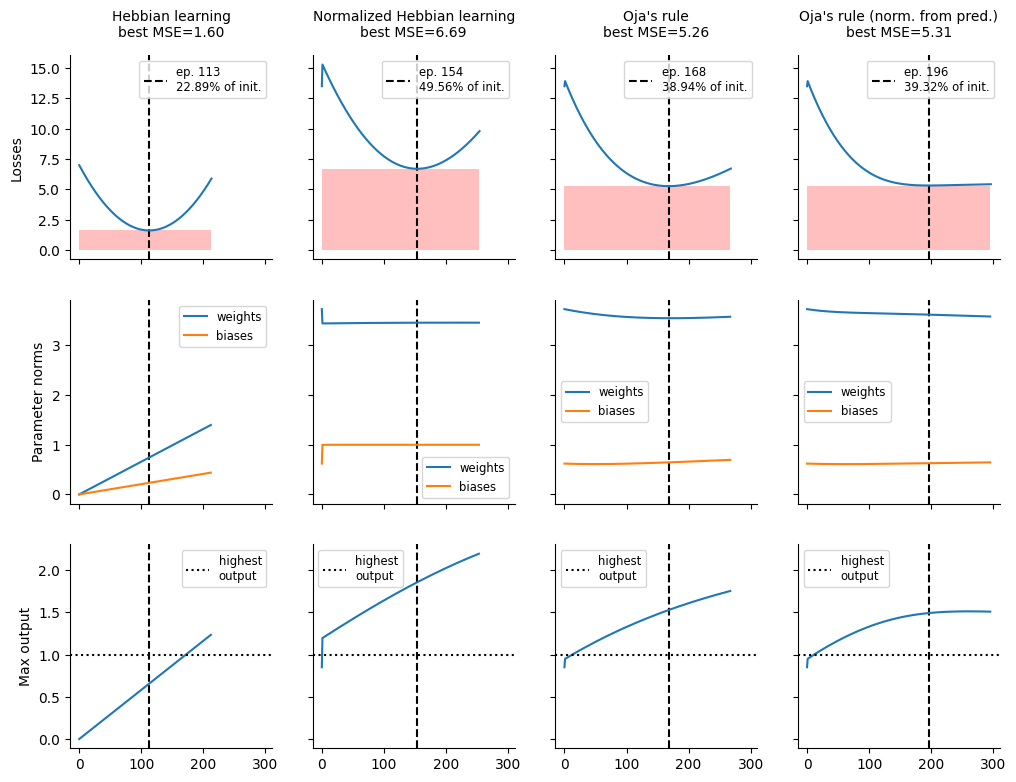

In [6]:
randst = np.random.RandomState(seed=SEED)
all_Is = [[randst.rand(n_I) for n_I in N_Is] for _ in range(N_EX)]
all_Os = randst.rand(N_EX, N_O)

fig, ax = plt.subplots(3, len(RULES), sharex=True, sharey="row", figsize=(12, 9))
for r, (rule, (rule_str, rule_fct)) in enumerate(RULES.items()):
    use_randst = copy.deepcopy(randst)
    if rule != "hebb":
        ws = [use_randst.normal(0, 0.3, N_O * n_I).reshape(N_O, n_I) for n_I in N_Is]
        b = use_randst.normal(0, 0.3, N_O)
    else:
        ws = [np.zeros((N_O, n_I)) for n_I in N_Is]
        b = np.zeros(N_O)

    rule_params = dict()
    if rule == "oja_pred":
        rule_params["norm_pred"] = True
        
    ws_norms = [weight_norm(ws)]
    b_norms = [weight_norm([b])]
    losses = [calc_all_losses(all_Is, ws, all_Os)]
    max_out = [calc_max_output(all_Is, ws)]
    
    best_loss, waited = np.inf, 0
    for e in range(MAX_EPOCHS):
        for i in range(N_EX):
            rule_fct(all_Is[i], ws, all_Os[i], b=b, **rule_params)
        losses.append(calc_all_losses(all_Is, ws, all_Os, b=b))
        if losses[-1] < best_loss:
            best_loss = losses[-1]
        else:
            waited += 1
            if waited >= WAIT:
                break
            
        ws_norms.append(weight_norm(ws))
        b_norms.append(weight_norm([b]))
        max_out.append(calc_max_output(all_Is, ws, b=b))

    best_loss_ep = np.argmin(losses)
    best_loss = losses[best_loss_ep]
    
    # mark best epoch
    label = f"ep. {best_loss_ep}\n{100 * best_loss / losses[0]:.2f}% of init."
    for i in range(3):
        ax[i, r].axvline(best_loss_ep, ls="dashed", color="k", label=label)
        label = None
    ax[0, r].legend(fontsize="small")
    
    # plot losses
    ax[0, r].plot(losses)
    rect = patches.Rectangle((0, 0), e, best_loss, lw=0, facecolor="red", alpha=0.25, zorder=-13)
    ax[0, r].add_patch(rect)
    
    # plot parameter norms
    ax[1, r].plot(ws_norms, label="weights")
    ax[1, r].plot(b_norms, label="biases")
    ax[1, r].legend(fontsize="small")
    
    # plot max output
    ax[2, r].plot(max_out)
    ax[2, r].axhline(all_Os.max(), ls="dotted", color="k", label="highest\noutput")
    ax[2, r].legend(fontsize="small");

    # add titles and axis labels
    ax[0, r].set_title(f"{rule_str}\nbest MSE={best_loss:.2f}", fontsize="medium", y=1.05);
    if r == 0:
        ax[0, r].set_ylabel("Losses")
        ax[1, r].set_ylabel("Parameter norms")
        ax[2, r].set_ylabel("Max output")

for sub_ax in ax.ravel():
    sub_ax.spines[["right", "top"]].set_visible(False)